In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

import sys
import importlib

sys.path.append(r"C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\8Q_Triangle_Lattice_v1")

import correlation_measurements.src_correlation_measurement
importlib.reload(correlation_measurements.src_correlation_measurement)
from correlation_measurements.src_correlation_measurement import RampOscillationShotsMeasurement, generate_ramp_double_jump_correlations_filename

import src.src_current_measurement
importlib.reload(src.src_current_measurement);
from src.src_current_measurement import CurrentMeasurementCalibration, generate_current_calibration_filename, acquire_data, generate_ramp_beamsplitter_correlations_filename, generate_ramp_beamsplitter_correlations_clean_filename



In [7]:
def post_select_counts(measurement, readout_pair_1, readout_pair_2, post_select=True):
     ### plot post selected data

    counts = measurement.get_counts()
    times = measurement.get_times()

    num_qubits = measurement.get_num_qubits()
    num_particles = 4


    bitstrings = list(product([0,1], repeat=num_qubits))
    bitstrings_n_particles = []

    counts_n_particles = []
    for i, bitstring in enumerate(bitstrings):
        if sum(bitstring) == num_particles or not post_select:
            bitstrings_n_particles.append(bitstring)
            counts_n_particles.append(counts[i, :])

    counts_n_particles = np.array(counts_n_particles, dtype=float)
    counts_n_particles_average = np.array(counts_n_particles, dtype=float)

    for j in range(counts_n_particles_average.shape[-1]):
        counts_n_particles_average[:,j] = counts_n_particles_average[:,j] / np.sum(counts_n_particles_average[:,j])

    counts_n_particles_average = np.array(counts_n_particles, dtype=float)
    counts_n_particles_average /= np.sum(counts_n_particles_average, axis=0)

    
    populations_post_selected = np.zeros((num_qubits, counts_n_particles_average.shape[-1]))
    for i in range(len(bitstrings_n_particles)):
        for j in range(num_qubits):
            if bitstrings_n_particles[i][j] == 1:
                populations_post_selected[j, :] += counts_n_particles_average[i, :]

    total_population = np.sum(populations_post_selected, axis=0)

    population_differences_post_selected = np.zeros((4, counts_n_particles.shape[-1]))
    population_differences_post_selected[0, :] = populations_post_selected[readout_pair_1[1], :] - populations_post_selected[readout_pair_1[0], :]
    population_differences_post_selected[1, :] = populations_post_selected[readout_pair_2[1], :] - populations_post_selected[readout_pair_2[0], :]

    return populations_post_selected, counts_n_particles, bitstrings_n_particles, 

def get_post_selected_covariance(measurement, populations_post_selected, counts_n_particles, bitstrings_n_particles, readout_pair_1, readout_pair_2, plot_individual_terms=False):

    times = measurement.get_times()

    covariance_post_selected = np.zeros((8, 8, counts_n_particles.shape[-1]))

    for i in range(len(bitstrings_n_particles)):
        for index_1 in range(covariance_post_selected.shape[0]):
            for index_2 in range(index_1, covariance_post_selected.shape[1]):
                if bitstrings_n_particles[i][index_1] == 1 and bitstrings_n_particles[i][index_2] == 1:
                    covariance_post_selected[index_1, index_2, :] += counts_n_particles[i, :]/np.sum(counts_n_particles, axis=0)
                

    for i in range(covariance_post_selected.shape[0]):
        for j in range(covariance_post_selected.shape[1]):
            if i == j:
                covariance_post_selected[i, j, :] = populations_post_selected[i, :] * (1 - populations_post_selected[i, :])
            elif i > j:
                covariance_post_selected[i, j, :] = covariance_post_selected[j, i, :]
            else:
                covariance_post_selected[i, j, :] -= populations_post_selected[i, :] * populations_post_selected[j, :]



    
    n3n4 = covariance_post_selected[readout_pair_2[0], readout_pair_2[1], :]
    n2n4 = covariance_post_selected[readout_pair_1[1], readout_pair_2[1], :]
    n2n3 = covariance_post_selected[readout_pair_1[1], readout_pair_2[0], :]
    n1n4 = covariance_post_selected[readout_pair_1[0], readout_pair_2[1], :]
    n1n3 = covariance_post_selected[readout_pair_1[0], readout_pair_2[0], :]
    n1n2 = covariance_post_selected[readout_pair_1[0], readout_pair_1[1], :]


    if plot_individual_terms:
        fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=True)
        axes = axes.flatten()

        n_terms = [n1n2, n1n3, n1n4, n2n3, n2n4, n3n4]

        labels = []
        for index_1 in readout_pair_1 + readout_pair_2:
            for index_2 in readout_pair_1 + readout_pair_2:
                if index_2 > index_1:
                    labels.append(f'n{index_1+1}n{index_2+1}')



        for ax, term, label in zip(axes, n_terms, labels):
            ax.plot(times, term, 'o--')
            ax.set_title(f'Population {label}')
            ax.set_ylabel('Population')
            ax.grid(True, alpha=0.3) 

        plt.show()


    covariance_sum = n1n3 - n1n4 - n2n3 + n2n4

    return covariance_post_selected, covariance_sum


def plot_post_selected_covariance_sum(measurement, covariance_sum, readout_pair_1, readout_pair_2, beamsplitter_time=None, ylim=None):
   
    times = measurement.get_times()

    plt.plot(times, covariance_sum, 'o--')
    plt.xlabel('Time (ns)')
    plt.ylabel('Current Correlation')

    if ylim is not None:
        plt.ylim(*ylim)

    if beamsplitter_time is not None:
        plt.axvline(beamsplitter_time, color='r', alpha=0.4, linestyle='--', label='Beamsplitter Time')

    correlator_symbol = f'$\\langle j_{{{readout_pair_1[0]+1}{readout_pair_1[1]+1}}}j_{{{readout_pair_2[0]+1}{readout_pair_2[1]+1}}}\\rangle$ '
    plt.title(f'Post-Selected Current Correlations {correlator_symbol} for 8 qubits')
    plt.show()




In [51]:
import numpy as np

def apply_confusion_matrix_all_qubits(counts_8, confusion_matrices):
    """
    Apply readout correction to all 8 qubits efficiently using 2x2 inversions per qubit.
    counts_8: ndarray of length 2^8 = 256
    confusion_matrices: list of 8 2x2 matrices
    Returns corrected probabilities (sum normalized to 1)
    """
    N_qubits = 8
    counts_nd = counts_8.reshape([2]*N_qubits).astype(float)
    
    for axis, q in enumerate(range(N_qubits)):
        C_inv = np.linalg.inv(confusion_matrices[q])
        counts_nd = np.tensordot(C_inv, counts_nd, axes=(1, axis))
        counts_nd = np.moveaxis(counts_nd, 0, axis)
    
    p_true = counts_nd.flatten()
    p_true = np.clip(p_true, 0, None)
    p_true /= np.sum(p_true)
    return p_true

def compute_order_parameter(p_true_4qubit):
    """
    Compute O = <n1 n3> - <n1 n4> - <n2 n3> + <n2 n4>
    Assumes p_true_4qubit is 4-qubit probability array flattened to length 16
    """
    p_array = p_true_4qubit.reshape([2,2,2,2])
    n = np.array([0,1])
    n_i = n[:,None,None,None]
    n_j = n[None,:,None,None]
    n_k = n[None,None,:,None]
    n_l = n[None,None,None,:]

    O = (
        np.sum(p_array * n_i * n_k) -
        np.sum(p_array * n_i * n_l) -
        np.sum(p_array * n_j * n_k) +
        np.sum(p_array * n_j * n_l)
    )
    return O

def bootstrap_order_parameter_all_times(counts_raw_2d, confusion_matrices, readout_pair_1, readout_pair_2, n_boot=1000, seed=None, verbose=True):
    """
    Bootstrap the order parameter O for two readout pairs across multiple time slices.
    Correct order: apply confusion matrices -> post-select 4-particle states -> marginalize -> compute O

    counts_raw_2d: ndarray of shape (256, num_times) raw counts for 8 qubits
    confusion_matrices: list of 8 2x2 matrices
    readout_pair_1: list of 2 qubit indices
    readout_pair_2: list of 2 qubit indices
    """
    rng = np.random.default_rng(seed)
    N_qubits = 8
    num_times = counts_raw_2d.shape[1]
    qubits = readout_pair_1 + readout_pair_2
    results_list = []

    # Precompute mask for 4-particle states among all 8 qubits
    mask_4particle = np.array([bin(x).count("1") == 4 for x in range(256)])

    for t in range(num_times):
        counts_slice = counts_raw_2d[:, t]
        N_shots = np.sum(counts_slice)
        if verbose:
            print(f"\nTime slice {t}: total counts = {N_shots}")

        if N_shots == 0:
            results_list.append({'mean': np.nan, 'std': np.nan, 'ci': [np.nan, np.nan], 'samples': np.array([])})
            continue

        counts_indices = np.repeat(np.arange(len(counts_slice)), counts_slice)
        O_samples = []

        for b in range(n_boot):
            # Resample raw shots
            resampled_indices = rng.choice(counts_indices, size=N_shots, replace=True)
            counts_resampled = np.bincount(resampled_indices, minlength=len(counts_slice))

            # Apply confusion matrices to all 8 qubits
            p_corrected = apply_confusion_matrix_all_qubits(counts_resampled, confusion_matrices)
            if verbose and b == 0:
                print("  After confusion correction sum:", np.sum(p_corrected))

            # Post-select on 4-particle states (8 qubits)
            p_post = p_corrected[mask_4particle]
            if np.sum(p_post) == 0:
                continue  # skip sample if no 4-particle states
            p_post /= np.sum(p_post)  # normalize

            if verbose and b == 0:
                print("  After 4-particle post-selection sum:", np.sum(p_post))

            # Marginalize to 4 qubits of interest
            counts_nd = np.zeros([2]*8)
            counts_nd_flat = p_post * np.sum(counts_resampled)  # scale back to counts
            counts_nd_flat_full = np.zeros(256)
            counts_nd_flat_full[mask_4particle] = counts_nd_flat
            counts_nd = counts_nd_flat_full.reshape([2]*8)

            axes_to_sum = [q for q in range(8) if q not in qubits]
            counts_4 = counts_nd
            for axis in sorted(axes_to_sum, reverse=True):
                counts_4 = counts_4.sum(axis=axis)
            p_4 = counts_4.flatten()
            p_4 /= np.sum(p_4)

            # Compute order parameter
            O_samples.append(compute_order_parameter(p_4))

        O_samples = np.array(O_samples)
        if verbose:
            print(f"  Bootstrap samples collected: {len(O_samples)}")
        results_list.append({
            "mean": np.mean(O_samples) if len(O_samples) > 0 else np.nan,
            "std": np.std(O_samples, ddof=1) if len(O_samples) > 1 else np.nan,
            "ci": np.percentile(O_samples, [2.5, 97.5]) if len(O_samples) > 0 else [np.nan, np.nan],
            "samples": O_samples
        })

    return results_list


In [9]:
name_to_filename = {}

# 9/24/25 - 8Q
name_to_filename['4P8Q_1234'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '24', '16', '53', '27') # best
name_to_filename['4P8Q_1254'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '24', '16', '59', '42')




name_to_measurement = {}
for name in name_to_filename:
    name_to_measurement[name] = RampOscillationShotsMeasurement(name_to_filename[name])

In [10]:
state_even = '4P8Q_1234'
# state_even = '4P8Q_1278'
state_odd = '4P8Q_1254'

measurement_even = name_to_measurement[state_even]
measurement_odd = name_to_measurement[state_odd]

I
Q
Qubit_Readout_List
angle
confusion_matrix
corrected_nn
expt_samples
nn_correlations
population
population_corrected
population_shots
readout_list
threshold


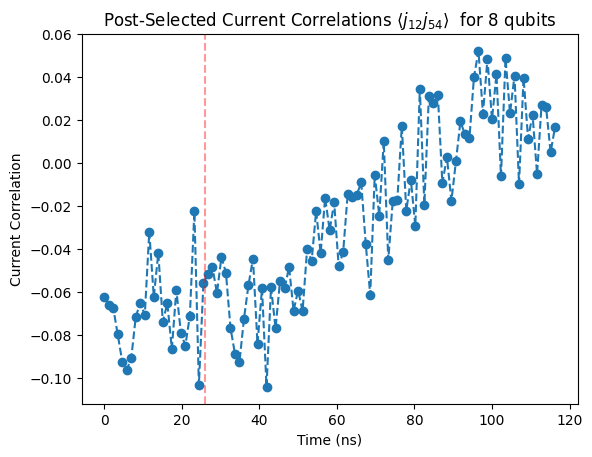

In [66]:
### test error bars

readout_pair_1 = [0, 1]
readout_pair_2 = [4, 3]

beamsplitter_time = 26 # ns

if abs(min(readout_pair_1)- min(readout_pair_2)) % 2 == 1:
    measurement = measurement_odd
else:
    measurement = measurement_even

populations_post_selected, counts_n_particles, bitstrings_n_particles = post_select_counts(measurement, readout_pair_1, readout_pair_2, post_select=True)
covariance_post_selected, covariance_sum = get_post_selected_covariance(measurement, populations_post_selected, counts_n_particles, bitstrings_n_particles, readout_pair_1, readout_pair_2, plot_individual_terms=False)
plot_post_selected_covariance_sum(measurement, covariance_sum, readout_pair_1, readout_pair_2, beamsplitter_time=beamsplitter_time)

In [67]:
confusion_matrices = measurement.get_confusion_matrices()

# test identity confusion matrices
confusion_matrices = [np.eye(2) for _ in range(8)]

counts = measurement.get_counts()

# counts_n_zeroed = counts.copy()
# non_4_particle_indices = [i for i, bits in enumerate(product([0,1], repeat=8)) if sum(bits) != 4]
# counts_n_zeroed[non_4_particle_indices, :] = 0

results = bootstrap_order_parameter_all_times(counts, confusion_matrices, readout_pair_1, readout_pair_2, n_boot=100,
                                              verbose=False)

for t, res in enumerate(results):
    print(f"Time slice {t}: O =", res["mean"], "+/-", res["std"], "CI:", res["ci"])

Time slice 0: O = 0.2210483921681619 +/- 0.01650238550133736 CI: [0.19646776 0.25625134]
Time slice 1: O = 0.1710077357135917 +/- 0.015548774535555311 CI: [0.14056471 0.19915173]
Time slice 2: O = 0.18465550599339647 +/- 0.017234149801112285 CI: [0.15251126 0.21610037]
Time slice 3: O = 0.176728790438379 +/- 0.01926574037684158 CI: [0.14227256 0.21111136]
Time slice 4: O = 0.17914983907954057 +/- 0.01529269273283066 CI: [0.1513471  0.20680314]
Time slice 5: O = 0.2026005708593882 +/- 0.014479010786567086 CI: [0.17596634 0.22951634]
Time slice 6: O = 0.18711086599837973 +/- 0.017801720567126415 CI: [0.15649143 0.21907219]
Time slice 7: O = 0.1773597514467247 +/- 0.016986820350443518 CI: [0.14266056 0.20751042]
Time slice 8: O = 0.13107953480127302 +/- 0.015237679238958057 CI: [0.10193148 0.15781807]
Time slice 9: O = 0.14189776876098945 +/- 0.016196036736597703 CI: [0.10785428 0.16578428]
Time slice 10: O = 0.08656663444754976 +/- 0.019118323854263562 CI: [0.04890054 0.11626574]
Time sl

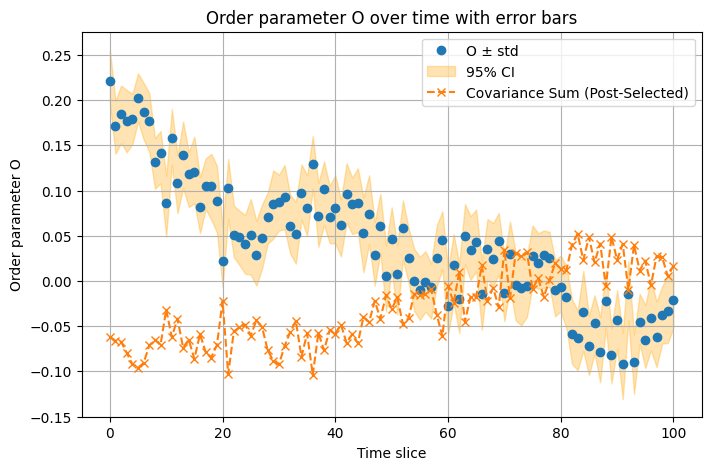

In [68]:
# Extract means and standard deviations
means = [res["mean"] for res in results]
stds  = [res["std"] for res in results]

# Alternatively, extract 95% CI
ci_lower = [res["ci"][0] for res in results]
ci_upper = [res["ci"][1] for res in results]

num_times = len(results)
times = np.arange(num_times)  # or use actual time points if available

plt.figure(figsize=(8,5))

# Plot mean with standard deviation error bars
# plt.errorbar(times, means, yerr=stds, fmt='o', capsize=4, label='O ± std')
plt.plot(times, means, 'o', label='O ± std')

# Optional: plot 95% CI as shaded area
plt.fill_between(times, ci_lower, ci_upper, color='orange', alpha=0.3, label='95% CI')

plt.plot(times, covariance_sum, 'x--', label='Covariance Sum (Post-Selected)')

plt.xlabel("Time slice")
plt.ylabel("Order parameter O")
plt.title("Order parameter O over time with error bars")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
### plot post selected data


post_select = True
plot_individual_terms = False

rung_to_readout_pairs = {
    2: [[0, 1], [2, 3]],
    3: [[0, 1], [4, 3]],
    4: [[0, 1], [4, 5]],
    5: [[0, 1], [6, 5]],
    6: [[0, 1], [6, 7]],
}

J_12 = 6.02*2*np.pi
rung_to_coupling = {
    2: 6.01*2*np.pi,
    3: 6.23*2*np.pi,
    4: 6.07*2*np.pi,
    5: 5.83*2*np.pi,
    6: 6.37*2*np.pi,
}

beamsplitter_offset = 5

plot_rungs = [2,4,6]
plot_rungs = [3,5]
plot_rungs = [2, 3, 4, 5, 6]
ylim = (-0.35, 0.35)

correlations_data = []

for rung in plot_rungs:
    if not rung in rung_to_readout_pairs:
        continue
    readout_pair_1, readout_pair_2 = rung_to_readout_pairs[rung]

    print(f'Rung {rung}:')

    average_coupling = (J_12 + rung_to_coupling[rung])/2
    beamsplitter_time = abs((np.pi/4)/(average_coupling))*1e3 + beamsplitter_offset  # in ns
    print(f'beamsplitter time: {beamsplitter_time:.2f} ns')

    print(rung_to_readout_pairs[rung])
    if rung % 2 == 0:
        measurement = measurement_even
    else:
        measurement = measurement_odd
        
    populations_post_selected, counts_n_particles, bitstrings_n_particles = post_select_counts(measurement, readout_pair_1, readout_pair_2, post_select=post_select)
    covariance_post_selected, covariance_sum = get_post_selected_covariance(measurement, populations_post_selected, counts_n_particles, bitstrings_n_particles, readout_pair_1, readout_pair_2, plot_individual_terms=plot_individual_terms)
    plot_post_selected_covariance_sum(measurement, covariance_sum, readout_pair_1, readout_pair_2, beamsplitter_time=beamsplitter_time, ylim=ylim)

    # plot_select_counts(measurement, readout_pair_1, readout_pair_2, beamsplitter_time=beamsplitter_time, ylim=ylim, post_select=post_select, plot_individual_terms=plot_individual_terms)

    current_correlation_index = np.argmin(np.abs(measurement.get_times() - beamsplitter_time))
    current_correlation_value = covariance_sum[current_correlation_index]

    print(f'Current correlation at beamsplitter time for rungs ({readout_pair_1[0]+1},{readout_pair_1[1]+1}) and ({readout_pair_2[0]+1},{readout_pair_2[1]+1}): {current_correlation_value:.4f}')
    correlations_data.append(current_correlation_value)